In [2]:
import gc
import logging
logging.disable(logging.WARNING)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
import tensorflow_addons as tfa

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

D:\Program Files\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


2.8.0


In [2]:
# Load data
df = pd.read_parquet('E:/train_low_mem.parquet')
df.drop(['row_id', 'time_id'], inplace=True, axis=1)
y = df.pop("target")
investment_id = df.pop("investment_id")

In [3]:
def preprocess(x, y):
    # flatten and normalize
    return x, tf.math.sign(y) * tf.math.log(1+tf.math.log(1+tf.math.abs(y)))

def post_process(y):
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_dataset(feature, y, batch_size=10240, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices((feature, y))
    ds = ds.map(preprocess)
    if mode == "train": ds = ds.shuffle(10240, seed=69)  # only shuffle when training
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# Pearson correlation coefficient loss and metrics
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    corr_loss = 1 - pearson_corr(y_true, y_pred, axis=axis)
    return corr_loss + mse

In [9]:
# Model
def build_model():
    features_inputs = Input((300, ), name='feature_in', dtype=tf.float16)
    x = GaussianNoise(0.1)(features_inputs)
    x = Dense(256)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.35)(x)
    x = Dense(64, activity_regularizer='l2')(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    xOut = Dense(1, name='output', dtype=tf.float32)(x)

    model = Model(inputs=features_inputs, outputs=xOut)
    # todo: try opt below with mish activation
    opt = tfa.optimizers.RectifiedAdam()
    opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=5e-4)
    model.compile(loss='mse', optimizer=opt, metrics=[pearson_corr, 'mse'])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_in (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 300)          0           feature_in[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          77056       gaussian_noise[0][0]             
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 256)          0           dense[0][0]                      
______________________________________________________________________________________________

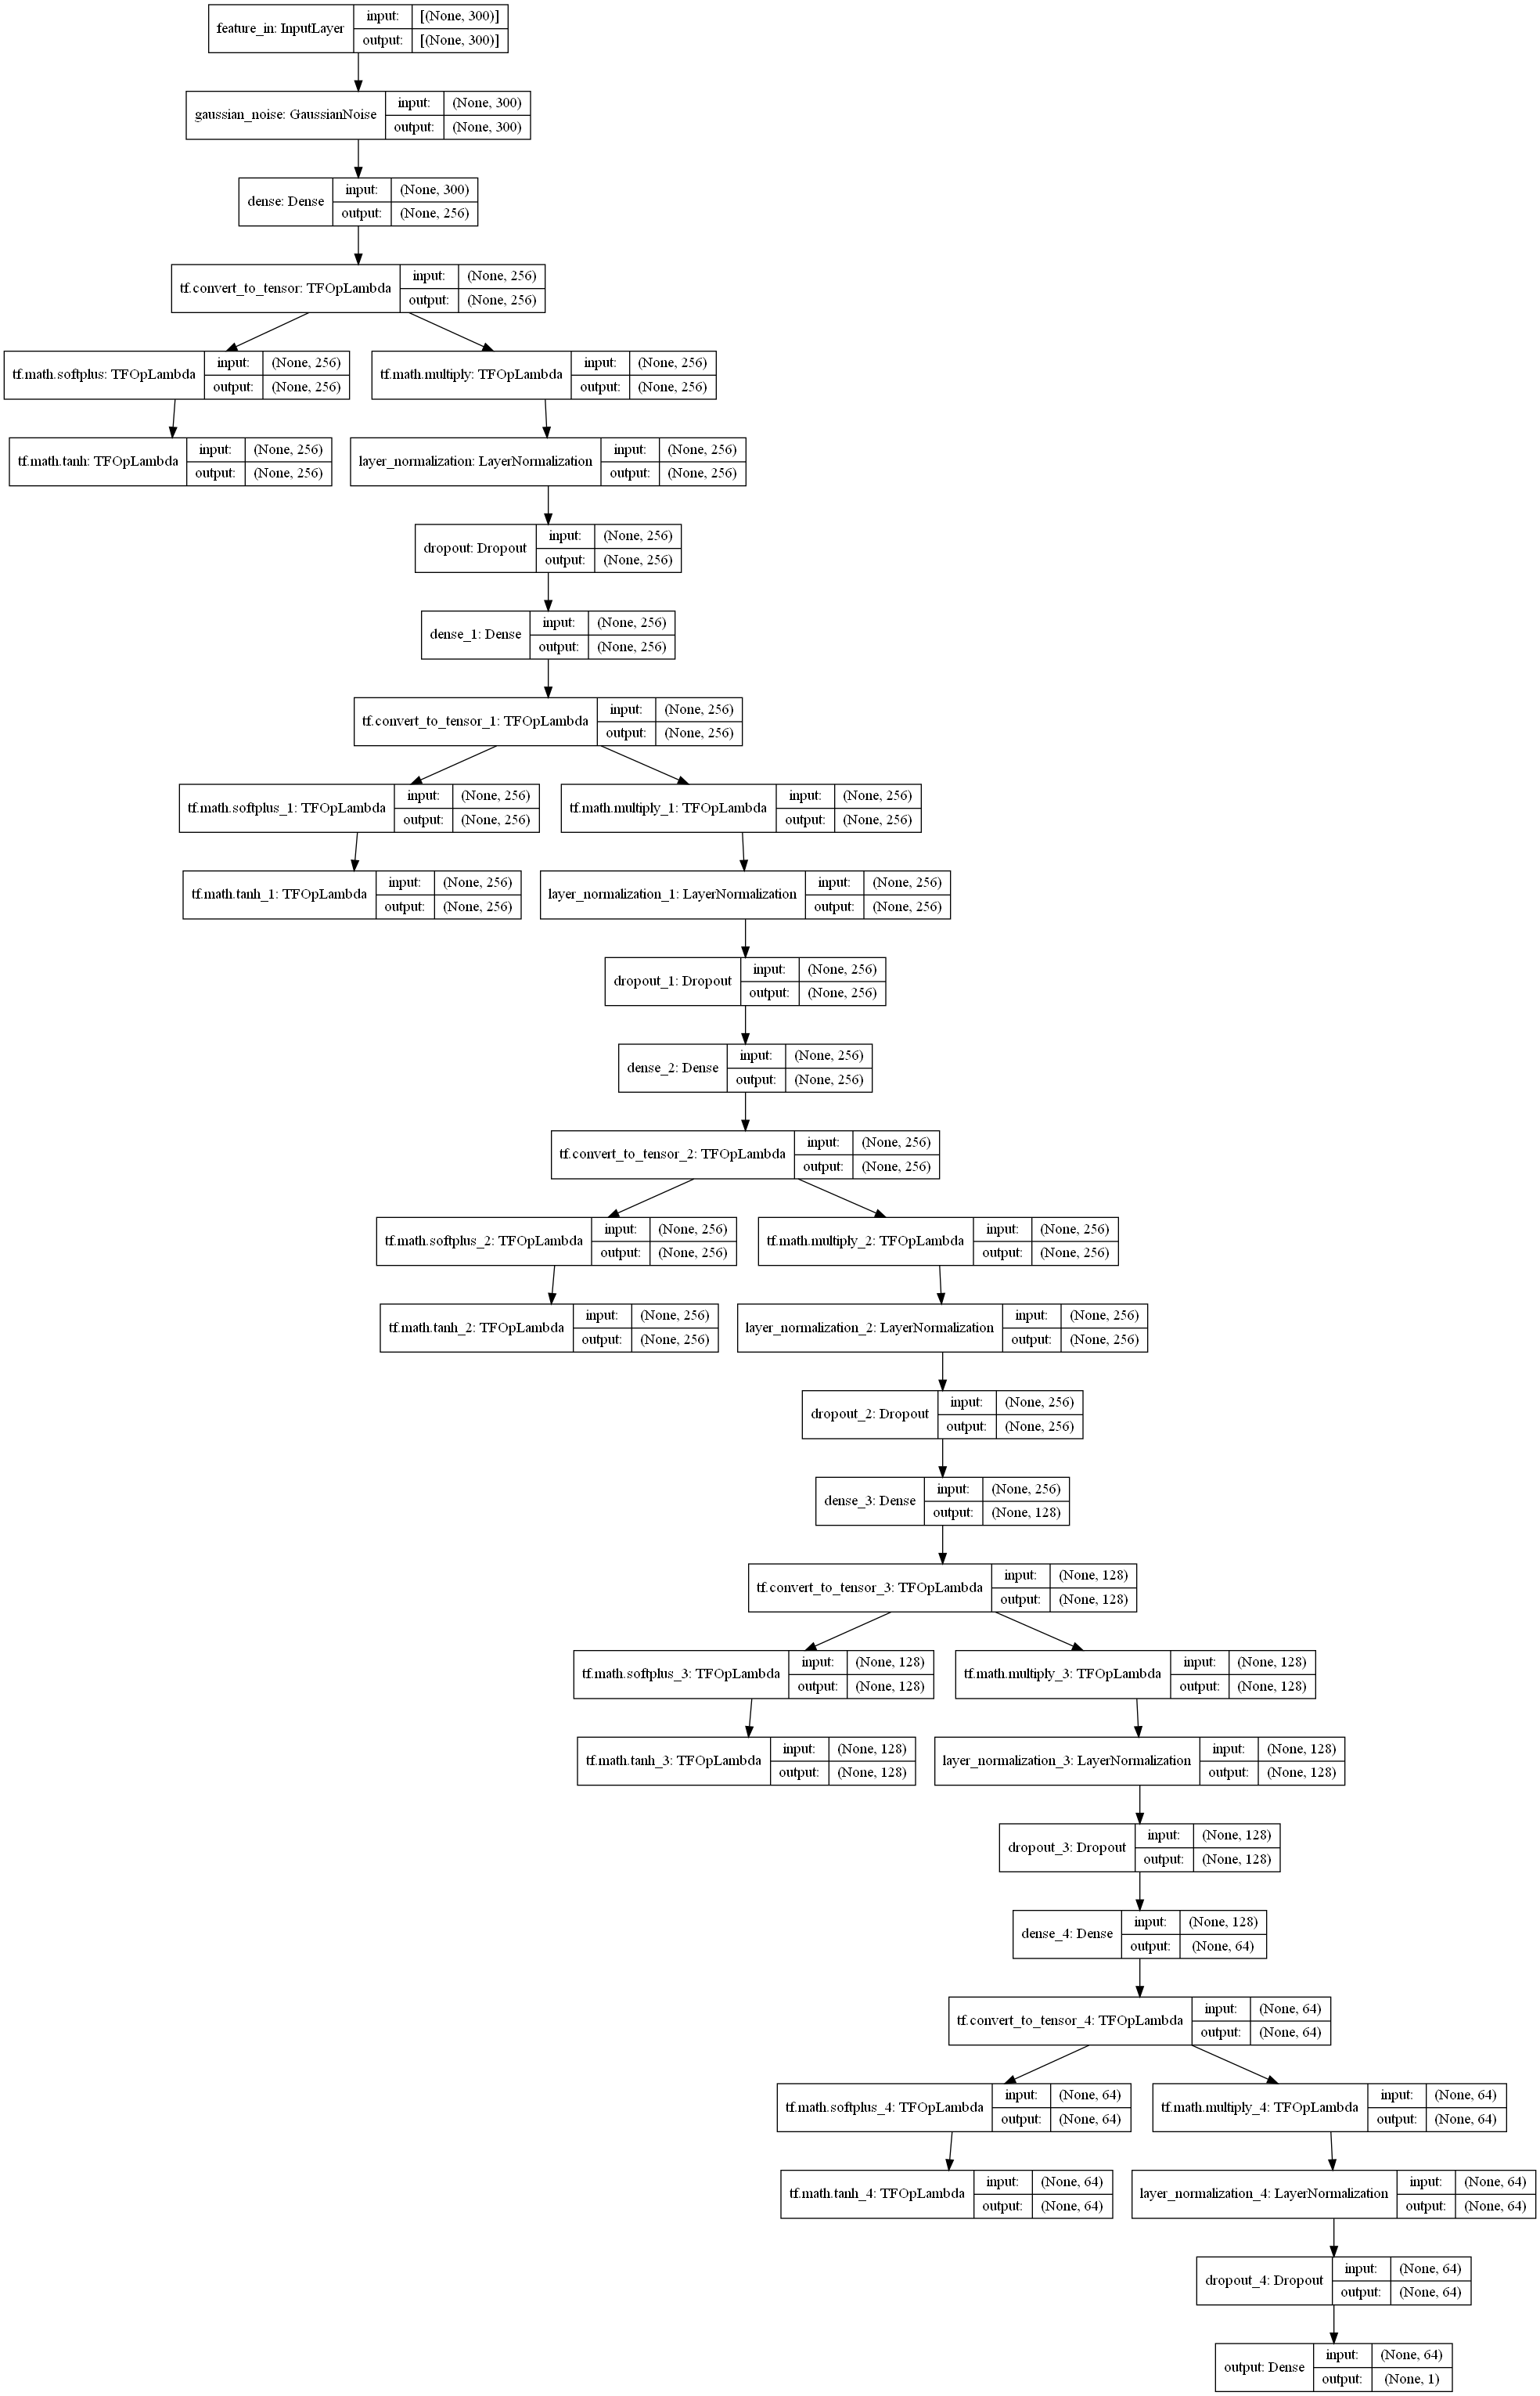

In [5]:
model = build_model()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
import scipy
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=69)
# group_time_series_split = GroupTimeSeriesSplit(n_folds=6, holdout_size=200, groups=df['time_id'])
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(df, investment_id)):
    print(f'Model {index}')
    X_train, X_val = df.iloc[train_indices], df.iloc[valid_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    train_ds = make_dataset(X_train, y_train)
    valid_ds = make_dataset(X_val, y_val, mode="valid")
    model = build_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", monitor='val_mse', save_best_only=True, mode='min'),
                 tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min')]
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}))

    pearson_score = scipy.stats.pearsonr(post_process(model.predict(valid_ds)), y_val.values)[0]
    print('Pearson:', pearson_score)
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


Model 0
Epoch 1/100
256/256 [==============================] - 12s 28ms/step - loss: inf - pearson_corr: 0.0031 - mse: 2.3798 - val_loss: inf - val_pearson_corr: 0.0329 - val_mse: 0.8964
Epoch 2/100
256/256 [==============================] - 5s 20ms/step - loss: inf - pearson_corr: 0.0050 - mse: 1.2188 - val_loss: inf - val_pearson_corr: 0.0418 - val_mse: 0.8393
Epoch 3/100
256/256 [==============================] - 3s 13ms/step - loss: inf - pearson_corr: 0.0044 - mse: 0.9659 - val_loss: 0.8780 - val_pearson_corr: 0.0340 - val_mse: 0.8401
Epoch 4/100
256/256 [==============================] - 3s 12ms/step - loss: inf - pearson_corr: 0.0032 - mse: 0.8892 - val_loss: 0.8540 - val_pearson_corr: 0.0358 - val_mse: 0.8396
Epoch 5/100
256/256 [==============================] - 3s 12ms/step - loss: 0.8866 - pearson_corr: 0.0040 - mse: 0.8669 - val_loss: 0.8481 - val_pearson_corr: 0.0526 - val_mse: 0.8403
Epoch 6/100
256/256 [==============================] - 3s 12ms/step - loss: 0.8706 - pear

In [11]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(feature):
    return feature, 0

def post_process(y):
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_test_dataset(feature, batch_size=10240):
    ds = tf.data.Dataset.from_tensor_slices(feature)
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(post_process(y_pred))
    return np.mean(y_preds, axis=0)  # ensemble

models = [load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# models = [load_model(f"model_comb", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss})]
# models += [load_model(f"1/model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# test = pd.read_parquet('E:/train_low_mem.parquet')
# time_ids = df['time_id'].unique()
# test = test.loc[test['time_id'].isin(time_ids)]  # take last 200 time id rows from df
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test)
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'])
    sample_prediction_df['target'] = inference(models, ds)
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {iter_test.score()}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
       row_id    target
18211     8_1  0.034016
18212     8_2  0.049509
18213     8_6  0.016259
18214     8_7  0.002830
18215     8_8  0.005807
...       ...       ...
19995  8_2961 -0.106372
19996  8_2963 -0.003959
19997  8_2964 -0.256319
19998  8_2965  0.004067
19999  8_2966 -0.085580

[1789 rows x 2 columns]
Pearson: (       row_id    target  prediction
0         0_1 -0.300875    0.115791
1         0_2 -0.231040   -0.041734
2         0_6  0.568807    0.016171
3         0_7 -1.064780   -0.103610
4         0_8 -0.531940   -0.006319
...       ...       ...         ...
19995  8_2961  2.395875   -0.106372
19996  8_2963  0.293830   -0.003959
19997  8_2964  0.295464   -0.256319
19998  8_2965 -0.722136    0.004067
19999  8_2966 -0.268326   -0.085580

[20000 rows x 3 columns], 0.17103911086843124)


In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

ModuleNotFoundError: No module named 'ubiquant'